In [22]:
import numpy as np

from timeit import default_timer as timer
from datetime import timedelta

from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.cross_validation import KFold
import seaborn as sns
import pandas as pd
import pickle
# Classifiers
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB 
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

def load(fname, fname2, oneHot=False):
    d = []
    with open(fname) as o:
        for line in o:
            d.append( line.strip().rsplit(' ', 4) )
    q1, fs1, qsqr1, magic1, y1 = list(zip(*d))
    
    d2 = []
    with open(fname2) as o:
        for line in o:
            d2.append( line.strip().rsplit(' ', 4) )
    q2, fs2, qsqr2, magic2, y2 = list(zip(*d2))
    
    predicates = []
    for query in q1:
        predicate = query.split('(')[0]
        predicates.append(predicate)
    cntTraining = len(q1)
    for query in q2:
        predicate = query.split('(')[0]
        predicates.append(predicate)
    cntTest = len(q2)

    if oneHot:
        values = array(predicates)
        # integer encode
        label_encoder = LabelEncoder()
        integer_encoded = label_encoder.fit_transform(values)
        # binary encode
        d={i for i in integer_encoded}
        onehot_encoder = OneHotEncoder(sparse=False)
        integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
        onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
        #print("Shape of one-hot matrix", np.shape(onehot_encoded))
        #print(onehot_encoded[0])

    yTrain = [int(i) for i in y1]
    XTrain = [[float(v) for v in f.split(',')] for f in fs1]
    #Normalize the feature vector
    XTrain = np.log1p(XTrain)
    #print ("Shape of training features before adding one-hot encoding : ", np.shape(XTrain))
    newXTrain = XTrain
    if oneHot:
        newXTrain = np.hstack((XTrain, onehot_encoded[:cntTraining]))
    #print ("Shape of training features after adding one-hot encoding : ", np.shape(newXTrain))

    qsqrTimesTrain = [float(i) for i in qsqr1]
    magicTimesTrain = [float(i) for i in magic1]
    
    
    yTest = [int(i) for i in y2]
    XTest = [[float(v) for v in f.split(',')] for f in fs2]
    #Normalize the feature vector
    XTest = np.log1p(XTest)
    #print ("Shape of test features before adding one-hot encoding : ", np.shape(XTest))
    newXTest = XTest
    if oneHot:
        newXTest = np.hstack((XTest, onehot_encoded[cntTraining:]))
    #print ("Shape of test features after adding one-hot encoding : ", np.shape(newXTest))

    qsqrTimesTest = [float(i) for i in qsqr2]
    magicTimesTest = [float(i) for i in magic2]
    
    return np.array(newXTrain), np.array(yTrain), np.array(qsqrTimesTrain), np.array(magicTimesTrain), q1,\
        np.array(newXTest), np.array(yTest), np.array(qsqrTimesTest), np.array(magicTimesTest), q2
            


In [23]:
def analysis_extra_query_time(db, trainingFile, testFile, oneHot = False, sampleWeight = 6, log=False, avgExtraQueryTime=3600000, MODEL=SVC):
    if log:
        print('Database : %s'% db)
        print('Sample weight : %d'% sampleWeight)
        print('One hot : %d'% oneHot)
        print()
    x, y, trainingQsqrTimes, trainingMagicTimes, qTraining, xTest, yTest, testQsqrTimes, testMagicTimes, qTest = load(trainingFile, testFile, oneHot)
    
    # Shuffle the features
    i = np.arange(len(y))
    np.random.shuffle(i)
    x, y = np.array(x)[i], np.array(y)[i]
    print(np.shape(x))
    tq, tm = np.array(trainingQsqrTimes)[i], np.array(trainingMagicTimes)[i]
    
    #countQsqrWinner = np.array(tq[i] <= tm[i]).sum()
    #countMagicWinner= np.array(tq[i] > tm[i]).sum()
    countQsqrWinner = np.array(tq[i] < tm[i]).sum()
    countMagicWinner= np.array(tq[i] >= tm[i]).sum()
    
    if countQsqrWinner < countMagicWinner:
        print ("More QSQR favouring queries than Magic sets")
    
    if sampleWeight == -1:
        sampleWeight = countQsqrWinner / countMagicWinner
    print ("sample weight = ", sampleWeight)
    #print(tm)
    #timeDiff = np.subtract(tq, tm)
    # print (timeDiff)
    #print (np.average(timeDiff))
    
    sample_weight = np.array([sampleWeight if y_ else 1 for y_ in y])
    s = MODEL().fit(x,y, sample_weight=sample_weight)
    # s = MODEL().fit(X,y)
    overallModelScore = s.score(x, y)
    if log:
        print("Model score")
        print(overallModelScore)
        print()
    
    a,b = (s.predict(x)[np.array(y) == 0]==0).sum() , (np.array(y) == 0).sum()
    if log:
        print('QSQR Accuracy on entire training set %s / %s = %s' % (a, b, a/b))
    a, b = s.predict(x)[np.array(y) == 1].sum() , (np.array(y) == 1).sum()
    if log:
        print('Magic Accuracy on entire training set %s / %s = %s' % (a, b, a/b))
        print()    
        print("Cross validation on training set:")
        
    folds = 1
    
    maxCrossValidationQsqrAccuracy = 0
    maxCrossValidationMagicAccuracy = 0
    maxCrossValidationAccuracy = 0
    for train_index, test_index in KFold(n=len(y), shuffle=True):
        X_train, y_train = x[train_index], y[train_index]
        X_test, y_test = x[test_index], y[test_index]
        s = MODEL()
        #s.fit(X_train, y_train)
        s.fit(X_train, y_train, sample_weight=sample_weight[train_index])

        if log:
            print()
            print('Fold #%d'% folds)

        folds += 1
        
        a,b = (s.predict(X_train) == y_train).sum() , len(y_train)
        if log:
            print('Accuracy on training subset %s / %s = %s' % (a, b, a/b))
        a,b = (s.predict(X_train)[np.array(y_train) == 0]==0).sum() , (np.array(y_train) == 0).sum()
        if log:
            print('QSQR Accuracy on training subset %s / %s = %s' % (a, b, a/b))
        a,b = (s.predict(X_train)[np.array(y_train) == 1]==1).sum() , (np.array(y_train) == 1).sum()
        if log:
            print('Magic Accuracy on training subset %s / %s = %s' % (a, b, a/b))
            print()
            
        a,b = (s.predict(X_test) == y_test).sum() , len(y_test)
        if a/b > maxCrossValidationAccuracy:
            maxCrossValidationAccuracy = a/b
        if log:
            print('Accuracy on test subset %s / %s = %s' % (a, b, a/b))
        a,b = (s.predict(X_test)[np.array(y_test) == 0]==0).sum() , (np.array(y_test) == 0).sum()
        if a/b > maxCrossValidationQsqrAccuracy:
            maxCrossValidationQsqrAccuracy = a/b
        if log:
            print('QSQR Accuracy on test subset %s / %s = %s' % (a, b, a/b))
        a,b = (s.predict(X_test)[np.array(y_test) == 1]==1).sum() , (np.array(y_test) == 1).sum()
        if a/b > maxCrossValidationMagicAccuracy:
            maxCrossValidationMagicAccuracy = a/b
        if log:
            print('Magic Accuracy on test subset %s / %s = %s' % (a, b, a/b))

    if log:
        print()
    
    s = MODEL().fit(x,y, sample_weight=sample_weight)
    s.score(x, y)

    test_time_start = timer()
    measure = s.predict(xTest)
    test_time_end = timer()
    if log:
        print("Time to predict : ", timedelta(seconds = test_time_end - test_time_start))
    
    a,b = (s.predict(xTest) == yTest).sum() , len(yTest)
    testOverallAccuracy = a/b
    if log:
        print('Accuracy on test set %s / %s = %s' % (a, b, a/b))
    
    a,b = (s.predict(xTest)[np.array(yTest) == 0]==0).sum() , (np.array(yTest) == 0).sum()
    testQsqrAccuracy = a/b
    if log:
        print('QSQR Accuracy on test set %s / %s = %s' % (a, b, a/b))
    
    
    a,b = (s.predict(xTest)[np.array(yTest) == 1]==1).sum() , (np.array(yTest) == 1).sum()
    testMagicAccuracy = a/b
    sumAllQsqr = testQsqrTimes.sum()
    sumAllMagic = testMagicTimes.sum()
    if log:
        print('Magic Accuracy on test set %s / %s = %s' % (a, b, a/b))
        print("Total QSQR time  : %8f"% sumAllQsqr)
        print("Total Magic time : %8f"% sumAllMagic)
        
    actualTime = 0
    cntTimedout = 0
    idealTime = 0
    oneHourInMillis = avgExtraQueryTime
    
    modifiedSumAllQsqr = 0
    modifiedSumAllMagic = 0
    modifiedMinimumSum = 0
    for i,t in enumerate(s.predict(xTest)):
        actualTime += testQsqrTimes[i] if (t == 0) else testMagicTimes[i]
        
        idealTime += min(testQsqrTimes[i], testMagicTimes[i])
        
        if (testQsqrTimes[i] == 10000 and testMagicTimes[i] != 10000) or (testQsqrTimes[i] != 1000 and testMagicTimes[i] == 10000):
            if testQsqrTimes[i] == 10000:
                modifiedSumAllQsqr += oneHourInMillis
            else:
                modifiedSumAllMagic += oneHourInMillis
        else:
            modifiedSumAllQsqr += testQsqrTimes[i]
            modifiedSumAllMagic += testMagicTimes[i]
        
        if (t == 1 and testQsqrTimes[i] == 10000):
            cntTimedout += 1
    onlineTime = "Total Online time: " + str(actualTime)
    
    worked = False
    
    modifiedMinimumSum = min(modifiedSumAllQsqr, modifiedSumAllMagic)
    minimumSum = min(sumAllQsqr, sumAllMagic)
    
    if actualTime < minimumSum:
        if log:
            print("\x1b[36m%s\x1b[0m"%onlineTime)
        worked = True
    else:
        if log:
            print("\x1b[35m%s\x1b[0m"%onlineTime)
    
    if modifiedMinimumSum < idealTime:
        modifiedMinimumSum = minimumSum
    
    decrease = modifiedMinimumSum - actualTime
    percentDecrease = (decrease / modifiedMinimumSum ) *100
    
    if log:
        print ("modified Minimum sum (QSQR)  = ", modifiedSumAllQsqr)
        print ("modified Minimum sum (magic) = ", modifiedSumAllMagic)
        print ("modified Minimum sum         = ", modifiedMinimumSum)
        print ("Ideal time                   = " , idealTime)
        
    idealDecrease = modifiedMinimumSum - idealTime
    idealPercentDecrease = (idealDecrease / modifiedMinimumSum) * 100
    if log:
        print (cntTimedout , " queries were timed out with QSQR")
    return  str.format('%.2f'%(percentDecrease)), \
            str.format('%.2f'%(idealPercentDecrease)), \
            str.format('%.2f'%(testOverallAccuracy)), \
            str.format('%.2f'%(testQsqrAccuracy)), \
            str.format('%.2f'%(testMagicAccuracy))
#            str.format('%.2f'%(maxCrossValidationMagicAccuracy)), \
#            str.format('%.2f'%(maxCrossValidationQsqrAccuracy)), \
#            str.format('%.2f'%(maxCrossValidationAccuracy)), \
#            str.format('%.2f'%(overallModelScore))
    
    

In [24]:
def analysis(db, trainingFile, testFile, oneHot = False, sampleWeight = 6, log=False, columnToSkip=None, MODEL=SVC):
    if log:
        print('Database : %s'% db)
        print('Sample weight : %d'% sampleWeight)
        print('One hot : %d'% oneHot)
        print()
    x, y, trainingQsqrTimes, trainingMagicTimes, qTraining, xTest, yTest, testQsqrTimes, testMagicTimes, qTest = load(trainingFile, testFile, oneHot)
    
    if columnToSkip is not None:
        newX = np.delete(x, columnToSkip, 1)
        newTestX = np.delete(xTest, columnToSkip, 1)
        x = newX
        xTest = newTestX
        
    print(np.shape(x))
    # Shuffle the features
    i = np.arange(len(y))
    np.random.shuffle(i)
    x, y = np.array(x)[i], np.array(y)[i]
    tq, tm = np.array(trainingQsqrTimes)[i], np.array(trainingMagicTimes)[i]
    
    countQsqrWinner = np.array(tq[i] < tm[i]).sum()
    countMagicWinner= np.array(tq[i] >= tm[i]).sum()
    
    if countQsqrWinner < countMagicWinner:
        print ("Less QSQR favouring queries than Magic sets")
    
    if sampleWeight == -1:
        sampleWeight = countQsqrWinner / countMagicWinner
    print ("sample weight = ", sampleWeight)
    #print(tm)
    #timeDiff = np.subtract(tq, tm)
    # print (timeDiff)
    #print (np.average(timeDiff))

    sample_weight = np.array([sampleWeight if y_ else 1 for y_ in y])
    my_model = MODEL()
    start_time = timer() 
    s = my_model.fit(x,y, sample_weight=sample_weight)
    end_time = timer()
    print("Time to fit model  = ", timedelta(seconds=end_time -start_time))

    overallModelScore = s.score(x, y)
    if log:
        print("Model score")
        print(overallModelScore)
        print()
    
    a,b = (s.predict(x)[np.array(y) == 0]==0).sum() , (np.array(y) == 0).sum()
    if log:
        print('QSQR Accuracy on entire training set %s / %s = %s' % (a, b, a/b))
    a, b = s.predict(x)[np.array(y) == 1].sum() , (np.array(y) == 1).sum()
    if log:
        print('Magic Accuracy on entire training set %s / %s = %s' % (a, b, a/b))
        print()    
        print("Cross validation on training set:")
        
    folds = 1
    
    maxCrossValidationQsqrAccuracy = 0
    maxCrossValidationMagicAccuracy = 0
    maxCrossValidationAccuracy = 0
    for train_index, test_index in KFold(n=len(y), shuffle=True):
        X_train, y_train = x[train_index], y[train_index]
        X_test, y_test = x[test_index], y[test_index]
        s = MODEL()
        #s.fit(X_train, y_train)
        s.fit(X_train, y_train, sample_weight=sample_weight[train_index])

        if log:
            print()
            print('Fold #%d'% folds)

        folds += 1
        
        a,b = (s.predict(X_train) == y_train).sum() , len(y_train)
        if log:
            print('Accuracy on training subset %s / %s = %s' % (a, b, a/b))
        a,b = (s.predict(X_train)[np.array(y_train) == 0]==0).sum() , (np.array(y_train) == 0).sum()
        if log:
            print('QSQR Accuracy on training subset %s / %s = %s' % (a, b, a/b))
        a,b = (s.predict(X_train)[np.array(y_train) == 1]==1).sum() , (np.array(y_train) == 1).sum()
        if log:
            print('Magic Accuracy on training subset %s / %s = %s' % (a, b, a/b))
            print()
            
        a,b = (s.predict(X_test) == y_test).sum() , len(y_test)
        if a/b > maxCrossValidationAccuracy:
            maxCrossValidationAccuracy = a/b
        if log:
            print('Accuracy on test subset %s / %s = %s' % (a, b, a/b))
        a,b = (s.predict(X_test)[np.array(y_test) == 0]==0).sum() , (np.array(y_test) == 0).sum()
        if a/b > maxCrossValidationQsqrAccuracy:
            maxCrossValidationQsqrAccuracy = a/b
        if log:
            print('QSQR Accuracy on test subset %s / %s = %s' % (a, b, a/b))
        a,b = (s.predict(X_test)[np.array(y_test) == 1]==1).sum() , (np.array(y_test) == 1).sum()
        if a/b > maxCrossValidationMagicAccuracy:
            maxCrossValidationMagicAccuracy = a/b
        if log:
            print('Magic Accuracy on test subset %s / %s = %s' % (a, b, a/b))

    if log:
        print()
    
    s = MODEL().fit(x,y, sample_weight=sample_weight)
    model_file_name = db + "-model.pkl"
    with open(model_file_name, "wb") as fout:
        pickle.dump(s, fout)
        
    s.score(x, y)
    a,b = (s.predict(xTest) == yTest).sum() , len(yTest)
    testOverallAccuracy = a/b
    if log:
        print('Accuracy on test set %s / %s = %s' % (a, b, a/b))
    
    a,b = (s.predict(xTest)[np.array(yTest) == 0]==0).sum() , (np.array(yTest) == 0).sum()
    testQsqrAccuracy = a/b
    if log:
        print('QSQR Accuracy on test set %s / %s = %s' % (a, b, a/b))
    
    
    a,b = (s.predict(xTest)[np.array(yTest) == 1]==1).sum() , (np.array(yTest) == 1).sum()
    testMagicAccuracy = a/b
    sumAllQsqr = testQsqrTimes.sum()
    sumAllMagic = testMagicTimes.sum()
    if log:
        print('Magic Accuracy on test set %s / %s = %s' % (a, b, a/b))
        print("Total QSQR time  : %8f"% sumAllQsqr)
        print("Total Magic time : %8f"% sumAllMagic)
        
    actualTime = 0
    cntTimedout = 0
    idealTime = 0

    
    for i,t in enumerate(s.predict(xTest)):
        actualTime += testQsqrTimes[i] if (t == 0) else testMagicTimes[i]
        idealTime += min(testQsqrTimes[i], testMagicTimes[i])
        
        if (t == 1 and testQsqrTimes[i] == 10000):
            cntTimedout += 1
    onlineTime = "Total Online time: " + str(actualTime)
    
    worked = False
    
    minimumSum = min(sumAllQsqr, sumAllMagic)
    
    if actualTime < minimumSum:
        if log:
            print("\x1b[36m%s\x1b[0m"%onlineTime)
        worked = True
    else:
        if log:
            print("\x1b[35m%s\x1b[0m"%onlineTime)
    
    decrease = minimumSum - actualTime
    percentDecrease = (decrease / minimumSum ) *100
    
    if log:
        print ("modified Minimum sum (QSQR)  = ", sumAllQsqr)
        print ("modified Minimum sum (magic) = ", sumAllMagic)
        print ("modified Minimum sum         = ", minimumSum)
        print ("Ideal time                   = " , idealTime)
        
    idealDecrease = minimumSum - idealTime
    idealPercentDecrease = (idealDecrease / minimumSum) * 100
    if log:
        print (cntTimedout , " queries were timed out with QSQR")
    return  str.format('%.2f'%(percentDecrease)), \
            str.format('%.2f'%(idealPercentDecrease)), \
            str.format('%.2f'%(testOverallAccuracy)), \
            str.format('%.2f'%(testQsqrAccuracy)), \
            str.format('%.2f'%(testMagicAccuracy))
#            str.format('%.2f'%(maxCrossValidationMagicAccuracy)), \
#            str.format('%.2f'%(maxCrossValidationQsqrAccuracy)), \
#            str.format('%.2f'%(maxCrossValidationAccuracy)), \
#            str.format('%.2f'%(overallModelScore))
    
    

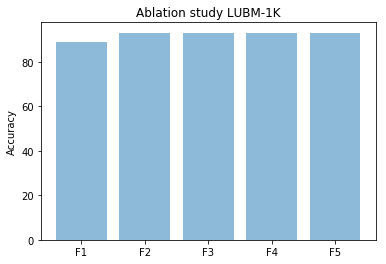

In [25]:
from matplotlib import pyplot as plt

features = ('F1', 'F2', 'F3', 'F4', 'F5')
y_pos = np.arange(len(features))
accuracy = [89,93,93,93,93]
plt.bar(y_pos, accuracy, align='center', alpha=0.5)
plt.xticks(y_pos, features)
plt.ylabel('Accuracy')
plt.title('Ablation study LUBM-1K')
plt.show()

In [15]:
print(analysis("Claros-LE", "claros-le-training.log", "claros-le-test.log"))

(1475, 6)
sample weight =  6
Time to fit model  =  0:00:00.033278
('31.68', '41.63', '0.89', '0.94', '0.41')


In [28]:
print(analysis("lubm-new","lubm_le-new-features-training.log", "lubm_le-new-features-test.log"))

(3386, 83)
sample weight =  6
Time to fit model  =  0:00:00.490991
('4.88', '7.72', '0.80', '0.87', '0.40')


In [21]:
for i in range(5):
    print ("With only feature : ", i)
    cols = [x for x in range(5) if x != i]
    print(cols)
    print (analysis("LUBM", 'freebase-training.log', 'freebase-test.log', columnToSkip=cols))

With only feature :  0
[1, 2, 3, 4]
(10000, 1)
sample weight =  6
Time to fit model  =  0:00:00.140283
('-17.11', '6.78', '0.86', '0.96', '0.50')
With only feature :  1
[0, 2, 3, 4]
(10000, 1)
sample weight =  6
Time to fit model  =  0:00:00.189955
('4.18', '6.78', '0.85', '0.84', '0.88')
With only feature :  2
[0, 1, 3, 4]
(10000, 1)
sample weight =  6
Time to fit model  =  0:00:00.145060
('-174.96', '6.78', '0.78', '1.00', '0.00')
With only feature :  3
[0, 1, 2, 4]
(10000, 1)
sample weight =  6
Time to fit model  =  0:00:00.141928
('-174.96', '6.78', '0.78', '1.00', '0.00')
With only feature :  4
[0, 1, 2, 3]
(10000, 1)
sample weight =  6
Time to fit model  =  0:00:00.143760
('-174.96', '6.78', '0.78', '1.00', '0.00')


In [44]:
print(analysis("LUBM-L", "LUBM_L-training.log", "LUBM_L-test.log"))

(3269, 5)
sample weight =  6
Time to fit model  =  0:00:00.098358
('14.44', '22.44', '0.86', '0.87', '0.76')


In [45]:
print(analysis("LUBM-LE", "LUBM_LE-training.log", "LUBM_LE-test.log"))

(3386, 5)
sample weight =  6
Time to fit model  =  0:00:00.138511
('4.92', '7.72', '0.86', '0.91', '0.59')


In [39]:
#for i in range(30):
#    print ('For sample weight (%d) : %% decrease = %s' % (i, analysis("Claros", "claros-training.log", "claros-test.log", False, i, False) ))
#analysis_extra_query_time("Claros", "claros-training.log", "claros-test.log", avgExtraQueryTime=30000)
print(analysis("Claros-L", "claros-l-training.log", "claros-l-test.log"))
print(analysis("Claros-L", "claros-l-training.log", "claros-l-test.log", MODEL=GaussianNB))
print(analysis("Claros-L", "claros-l-training.log", "claros-l-test.log", MODEL=LogisticRegression))
print(analysis("Claros-L", "claros-l-training.log", "claros-l-test.log", MODEL=DecisionTreeClassifier))

#for i in range(5):
#    print ("Without feature : ", i)
#    print (analysis("Claros", 'claros-l-training.log', 'claros-l-test.log', columnToSkip=i))

(1207, 6)
sample weight =  6
Time to fit model  =  0:00:00.022235
('29.05', '41.58', '0.93', '0.93', '0.81')
(1207, 6)
sample weight =  6
Time to fit model  =  0:00:00.001671
('-27.66', '41.58', '0.52', '0.49', '1.00')
(1207, 6)
sample weight =  6
Time to fit model  =  0:00:00.002880
('18.82', '41.58', '0.89', '0.90', '0.72')
(1207, 6)
sample weight =  6
Time to fit model  =  0:00:00.001695
('27.49', '41.58', '0.91', '0.90', '1.00')


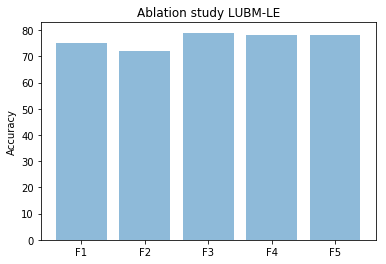

In [28]:
features = ('F1', 'F2', 'F3', 'F4', 'F5')
y_pos = np.arange(len(features))
accuracy = [75,72,79,78,78]
plt.bar(y_pos, accuracy, align='center', alpha=0.5)
fig = plt.gcf()
plt.xticks(y_pos, features)
plt.ylabel('Accuracy')
plt.title('Ablation study LUBM-LE')
plt.show()
fig.savefig("lubmLE-ablation-new.png")



In [66]:
print(analysis("Yago2", "yago2-training.log", "yago2-test.log", sampleWeight=1))
print(analysis("Yago2", "yago2-training.log", "yago2-test.log", sampleWeight=1, MODEL=GaussianNB))
print(analysis("Yago2", "yago2-training.log", "yago2-test.log", sampleWeight=1, MODEL=LogisticRegression))
print(analysis("Yago2", "yago2-training.log", "yago2-test.log", sampleWeight=1, MODEL=DecisionTreeClassifier))

for i in range(5):
    print ("Without feature : ", i)
    print (analysis("YAGO", 'yago2-training.log', 'yago2-test.log', sampleWeight=1, columnToSkip=i))



(1396, 5)
sample weight =  1
Time to fit model  =  0:00:00.037328
('-19.78', '0.04', '0.79', '0.73', '0.85')
(1396, 5)
sample weight =  1
Time to fit model  =  0:00:00.001931
('-41.63', '0.04', '0.71', '0.46', '0.97')
(1396, 5)
sample weight =  1
Time to fit model  =  0:00:00.002433
('-6.21', '0.04', '0.65', '0.89', '0.40')
(1396, 5)
sample weight =  1
Time to fit model  =  0:00:00.001584
('-23.90', '0.04', '0.79', '0.66', '0.93')
Without feature :  0
(1396, 4)
sample weight =  1
Time to fit model  =  0:00:00.026503
('-22.36', '0.04', '0.79', '0.69', '0.90')
Without feature :  1
(1396, 4)
sample weight =  1
Time to fit model  =  0:00:00.042221
('-19.78', '0.04', '0.79', '0.73', '0.85')
Without feature :  2
(1396, 4)
sample weight =  1
Time to fit model  =  0:00:00.040441
('-19.78', '0.04', '0.79', '0.73', '0.84')
Without feature :  3
(1396, 4)
sample weight =  1
Time to fit model  =  0:00:00.043729
('-19.16', '0.04', '0.79', '0.74', '0.84')
Without feature :  4
(1396, 4)
sample weight 

In [41]:
print(analysis("Freebase", "freebase-training.log", "freebase-test.log", sampleWeight=-1))
print(analysis("Freebase", "freebase-training.log", "freebase-test.log", sampleWeight=-1, MODEL=GaussianNB))
print(analysis("Freebase", "freebase-training.log", "freebase-test.log", sampleWeight=-1, MODEL=LogisticRegression))
print(analysis("Freebase", "freebase-training.log", "freebase-test.log", sampleWeight=-1, MODEL=DecisionTreeClassifier))


#for i in range(5):
#    print ("Without feature : ", i)
#    print (analysis("Freebase", 'freebase-training.log', 'freebase-test.log', sampleWeight=-1, columnToSkip=i))




(10000, 5)
sample weight =  128.87012987012986
Time to fit model  =  0:00:00.200258
('5.38', '6.78', '0.88', '0.88', '0.89')
(10000, 5)
sample weight =  128.87012987012986
Time to fit model  =  0:00:00.006914
('1.86', '6.78', '0.65', '0.57', '0.94')
(10000, 5)
sample weight =  128.87012987012986
Time to fit model  =  0:00:00.023758
('2.56', '6.78', '0.71', '0.65', '0.91')
(10000, 5)
sample weight =  128.87012987012986
Time to fit model  =  0:00:00.003742
('5.34', '6.78', '0.89', '0.90', '0.87')


In [42]:
#for i in range(30):
#    print ('For sample weight (%d) : %% decrease = %s' % (i, analysis("DBpedia", "DBpedia-700-training.log", "dbpedia-test.log", False, i, False) ))
#analysis_extra_query_time("DBpedia", "dbpedia-training.log", "dbpedia-test.log", avgExtraQueryTime=120000)

print(analysis("DBpedia", "dbp1", "dbpedia-test-new.log", sampleWeight=-1))
#print(analysis("DBpedia", "dbp1", "dbpedia-test-new.log", sampleWeight=-1, MODEL=GaussianNB))
#print(analysis("DBpedia", "dbp1", "dbpedia-test-new.log", sampleWeight=-1, MODEL=LogisticRegression))
#print(analysis("DBpedia", "dbp1", "dbpedia-test-new.log", sampleWeight=-1, MODEL=DecisionTreeClassifier))
#for i in range(5):
#    print ("Without feature : ", i)
#    print(analysis("DBpedia", "dbp1", "dbpedia-test-new.log", sampleWeight=-1, columnToSkip=i))

(15327, 5)
sample weight =  11.068503937007874
Time to fit model  =  0:00:06.977366
('8.16', '43.37', '0.63', '0.58', '0.92')


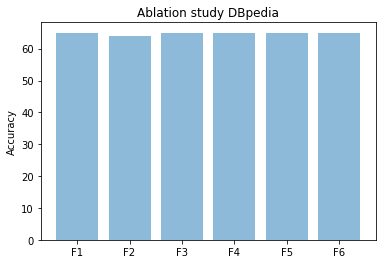

In [105]:
features = ('F1', 'F2', 'F3', 'F4', 'F5', 'F6')
y_pos = np.arange(len(features))
accuracy = [65,64,65,65,65,65]
plt.bar(y_pos, accuracy, align='center', alpha=0.5)
plt.xticks(y_pos, features)
plt.ylabel('Accuracy')
plt.title('Ablation study DBpedia')
plt.show()

In [69]:
def find_long_running_queries(db, trainingFile, testFile, oneHot = False, sampleWeight = 6, log=False):
    if log:
        print('Database : %s'% db)
        print('Sample weight : %d'% sampleWeight)
        print('One hot : %d'% oneHot)
        print()
    x, y, trainingQsqrTimes, trainingMagicTimes, qTrain, xTest, yTest, testQsqrTimes, testMagicTimes, qTest = load(trainingFile, testFile, oneHot)
    count = 0
    for i, t in enumerate(xTest):
        if (testQsqrTimes[i] == 10000 and testMagicTimes[i] != 10000) or (testQsqrTimes[i] != 10000 and testMagicTimes[i] == 10000):
            print (qTest[i], " : ", testQsqrTimes[i], " - " , testMagicTimes[i])
            count += 1
    print (count)
                
                
    

In [52]:
print (analysis_extra_query_time("LUBM-LE", 'LUBM_LE-training.log', 'LUBM_LE-test.log', sampleWeight=-1, log=True))
#print (analysis_extra_query_time("LUBM-LE", 'LUBM_LE-training.log', 'LUBM_LE-test.log', MODEL=LogisticRegression, sampleWeight=-1))
#print (analysis_extra_query_time("LUBM-LE", 'LUBM_LE-training.log', 'LUBM_LE-test.log', MODEL=GaussianNB, sampleWeight=-1))
#print (analysis_extra_query_time("LUBM-LE", 'LUBM_LE-training.log', 'LUBM_LE-test.log', MODEL=DecisionTreeClassifier, sampleWeight=-1))

Database : LUBM-LE
Sample weight : -1
One hot : 0

(3386, 5)
sample weight =  8.226158038147139
Model score
0.8086237448316598

QSQR Accuracy on entire training set 2415 / 3019 = 0.7999337528983107
Magic Accuracy on entire training set 323 / 367 = 0.8801089918256131

Cross validation on training set:

Fold #1
Accuracy on training subset 1830 / 2257 = 0.8108108108108109
QSQR Accuracy on training subset 1620 / 2022 = 0.8011869436201781
Magic Accuracy on training subset 210 / 235 = 0.8936170212765957

Accuracy on test subset 907 / 1129 = 0.8033658104517272
QSQR Accuracy on test subset 794 / 997 = 0.7963891675025075
Magic Accuracy on test subset 113 / 132 = 0.8560606060606061

Fold #2
Accuracy on training subset 1849 / 2257 = 0.8192290651307045
QSQR Accuracy on training subset 1624 / 2000 = 0.812
Magic Accuracy on training subset 225 / 257 = 0.8754863813229572

Accuracy on test subset 920 / 1129 = 0.8148804251550045
QSQR Accuracy on test subset 830 / 1019 = 0.8145240431795878
Magic Accurac

In [53]:
print (analysis_extra_query_time("LUBM", 'LUBM_L-training.log', 'LUBM_L-test.log', sampleWeight=-1, log=True))
#print (analysis_extra_query_time("LUBM", 'LUBM_L-training.log', 'LUBM_L-test.log', MODEL=LogisticRegression, sampleWeight=-1))
#print (analysis_extra_query_time("LUBM", 'LUBM_L-training.log', 'LUBM_L-test.log', MODEL=GaussianNB, sampleWeight=-1))
#print (analysis_extra_query_time("LUBM", 'LUBM_L-training.log', 'LUBM_L-test.log', MODEL=DecisionTreeClassifier, sampleWeight=-1))

Database : LUBM
Sample weight : -1
One hot : 0

(3269, 5)
sample weight =  8.34
Model score
0.8739675741817069

QSQR Accuracy on entire training set 2541 / 2919 = 0.8705035971223022
Magic Accuracy on entire training set 316 / 350 = 0.9028571428571428

Cross validation on training set:

Fold #1
Accuracy on training subset 1886 / 2179 = 0.8655346489215237
QSQR Accuracy on training subset 1678 / 1947 = 0.861838726245506
Magic Accuracy on training subset 208 / 232 = 0.896551724137931

Accuracy on test subset 969 / 1090 = 0.8889908256880734
QSQR Accuracy on test subset 862 / 972 = 0.8868312757201646
Magic Accuracy on test subset 107 / 118 = 0.9067796610169492

Fold #2
Accuracy on training subset 1835 / 2179 = 0.8421294171638366
QSQR Accuracy on training subset 1608 / 1945 = 0.8267352185089974
Magic Accuracy on training subset 227 / 234 = 0.9700854700854701

Accuracy on test subset 905 / 1090 = 0.8302752293577982
QSQR Accuracy on test subset 798 / 974 = 0.8193018480492813
Magic Accuracy on t

In [210]:
print (analysis_extra_query_time("LUBM", 'lubm-query-execution.log', 'lubm-1000-test.log'))
print (analysis_extra_query_time("LUBM", 'lubm-query-execution.log', 'lubm-1000-test.log', MODEL=GaussianNB))
print (analysis_extra_query_time("LUBM", 'lubm-query-execution.log', 'lubm-1000-test.log', MODEL=LogisticRegression))
print (analysis_extra_query_time("LUBM", 'lubm-query-execution.log', 'lubm-1000-test.log', MODEL=DecisionTreeClassifier))

(838, 6)
sample weight =  6
('20.46', '20.79', '0.93', '1.00', '0.35')
(838, 6)
sample weight =  6
('14.51', '20.79', '0.86', '0.90', '0.49')
(838, 6)
sample weight =  6
('5.84', '20.79', '0.82', '0.88', '0.33')
(838, 6)
sample weight =  6
('20.45', '20.79', '0.84', '0.86', '0.69')


In [54]:
print(analysis_extra_query_time("Claros", "claros-l-training.log", "claros-l-test.log", sampleWeight=-1, log=True))
#print(analysis_extra_query_time("Claros", "claros-l-training.log", "claros-l-test.log", MODEL=GaussianNB, sampleWeight=-1))
#print(analysis_extra_query_time("Claros", "claros-l-training.log", "claros-l-test.log", MODEL=LogisticRegression, sampleWeight=-1))
#print(analysis_extra_query_time("Claros", "claros-l-training.log", "claros-l-test.log", MODEL=DecisionTreeClassifier, sampleWeight=-1))

Database : Claros
Sample weight : -1
One hot : 0

(1207, 6)
sample weight =  4.293859649122807
Model score
0.8906379453189727

QSQR Accuracy on entire training set 991 / 1081 = 0.9167437557816837
Magic Accuracy on entire training set 84 / 126 = 0.6666666666666666

Cross validation on training set:

Fold #1
Accuracy on training subset 714 / 804 = 0.8880597014925373
QSQR Accuracy on training subset 653 / 715 = 0.9132867132867133
Magic Accuracy on training subset 61 / 89 = 0.6853932584269663

Accuracy on test subset 362 / 403 = 0.8982630272952854
QSQR Accuracy on test subset 341 / 366 = 0.9316939890710383
Magic Accuracy on test subset 21 / 37 = 0.5675675675675675

Fold #2
Accuracy on training subset 716 / 805 = 0.8894409937888199
QSQR Accuracy on training subset 660 / 721 = 0.9153952843273232
Magic Accuracy on training subset 56 / 84 = 0.6666666666666666

Accuracy on test subset 356 / 402 = 0.8855721393034826
QSQR Accuracy on test subset 328 / 360 = 0.9111111111111111
Magic Accuracy on te

In [55]:
print(analysis_extra_query_time("Claros", "claros-le-training.log", "claros-le-test.log", sampleWeight=-1, log=True))
#print(analysis_extra_query_time("Claros", "claros-l-training.log", "claros-l-test.log", MODEL=GaussianNB, sampleWeight=-1))
#print(analysis_extra_query_time("Claros", "claros-l-training.log", "claros-l-test.log", MODEL=LogisticRegression, sampleWeight=-1))
#print(analysis_extra_query_time("Claros", "claros-l-training.log", "claros-l-test.log", MODEL=DecisionTreeClassifier, sampleWeight=-1))

Database : Claros
Sample weight : -1
One hot : 0

(1475, 6)
sample weight =  4.383211678832117
Model score
0.8969491525423728

QSQR Accuracy on entire training set 1225 / 1324 = 0.925226586102719
Magic Accuracy on entire training set 98 / 151 = 0.6490066225165563

Cross validation on training set:

Fold #1
Accuracy on training subset 884 / 983 = 0.8992878942014242
QSQR Accuracy on training subset 825 / 884 = 0.9332579185520362
Magic Accuracy on training subset 59 / 99 = 0.5959595959595959

Accuracy on test subset 433 / 492 = 0.8800813008130082
QSQR Accuracy on test subset 404 / 440 = 0.9181818181818182
Magic Accuracy on test subset 29 / 52 = 0.5576923076923077

Fold #2
Accuracy on training subset 873 / 983 = 0.8880976602238047
QSQR Accuracy on training subset 798 / 868 = 0.9193548387096774
Magic Accuracy on training subset 75 / 115 = 0.6521739130434783

Accuracy on test subset 451 / 492 = 0.9166666666666666
QSQR Accuracy on test subset 428 / 456 = 0.9385964912280702
Magic Accuracy on t

In [56]:
print(analysis_extra_query_time("Freebase", "freebase-training.log", "freebase-test.log", sampleWeight=-1, log=True))
#print(analysis_extra_query_time("Freebase", "freebase-training.log", "freebase-test.log", sampleWeight=-1, MODEL=GaussianNB))
#print(analysis_extra_query_time("Freebase", "freebase-training.log", "freebase-test.log", sampleWeight=-1, MODEL=LogisticRegression))
#print(analysis_extra_query_time("Freebase", "freebase-training.log", "freebase-test.log", sampleWeight=-1, MODEL=DecisionTreeClassifier))

Database : Freebase
Sample weight : -1
One hot : 0

(10000, 5)
sample weight =  128.87012987012986
Model score
0.9765

QSQR Accuracy on entire training set 9688 / 9923 = 0.9763176458732238
Magic Accuracy on entire training set 77 / 77 = 1.0

Cross validation on training set:

Fold #1
Accuracy on training subset 6535 / 6666 = 0.9803480348034803
QSQR Accuracy on training subset 6484 / 6615 = 0.9801965230536659
Magic Accuracy on training subset 51 / 51 = 1.0

Accuracy on test subset 3266 / 3334 = 0.9796040791841631
QSQR Accuracy on test subset 3243 / 3308 = 0.9803506650544136
Magic Accuracy on test subset 23 / 26 = 0.8846153846153846

Fold #2
Accuracy on training subset 6443 / 6667 = 0.9664016799160042
QSQR Accuracy on training subset 6395 / 6619 = 0.9661580299138842
Magic Accuracy on training subset 48 / 48 = 1.0

Accuracy on test subset 3205 / 3333 = 0.9615961596159616
QSQR Accuracy on test subset 3177 / 3304 = 0.9615617433414043
Magic Accuracy on test subset 28 / 29 = 0.965517241379310

In [77]:
print(analysis_extra_query_time("Yago2", "yago2-training.log", "yago2-test.log", sampleWeight=-1, log=True))
#print(analysis_extra_query_time("Yago2", "yago2-training.log", "yago2-test.log", sampleWeight=1, avgExtraQueryTime=120000, MODEL=GaussianNB))
#print(analysis_extra_query_time("Yago2", "yago2-training.log", "yago2-test.log", sampleWeight=1, avgExtraQueryTime=120000, MODEL=LogisticRegression))
#print(analysis_extra_query_time("Yago2", "yago2-training.log", "yago2-test.log", sampleWeight=1, avgExtraQueryTime=120000, MODEL=DecisionTreeClassifier))

Database : Yago2
Sample weight : -1
One hot : 0

(1396, 5)
sample weight =  2.693121693121693
Model score
0.7313753581661891

QSQR Accuracy on entire training set 742 / 1018 = 0.7288801571709234
Magic Accuracy on entire training set 279 / 378 = 0.7380952380952381

Cross validation on training set:

Fold #1
Accuracy on training subset 682 / 930 = 0.7333333333333333
QSQR Accuracy on training subset 495 / 678 = 0.7300884955752213
Magic Accuracy on training subset 187 / 252 = 0.7420634920634921

Accuracy on test subset 336 / 466 = 0.721030042918455
QSQR Accuracy on test subset 245 / 340 = 0.7205882352941176
Magic Accuracy on test subset 91 / 126 = 0.7222222222222222

Fold #2
Accuracy on training subset 696 / 931 = 0.7475832438238453
QSQR Accuracy on training subset 527 / 682 = 0.7727272727272727
Magic Accuracy on training subset 169 / 249 = 0.678714859437751

Accuracy on test subset 351 / 465 = 0.7548387096774194
QSQR Accuracy on test subset 270 / 336 = 0.8035714285714286
Magic Accuracy on

In [68]:
print(analysis_extra_query_time("DBpedia", "dbp1", "dbpedia-test-new.log", sampleWeight=-1, avgExtraQueryTime=120000, log=True))
#print(analysis_extra_query_time("DBpedia", "dbp1", "dbpedia-test-new.log", sampleWeight=-1, MODEL=GaussianNB, avgExtraQueryTime=120000))
#print(analysis_extra_query_time("DBpedia", "dbp1", "dbpedia-test-new.log", sampleWeight=-1, MODEL=LogisticRegression, avgExtraQueryTime=120000))
#print(analysis_extra_query_time("DBpedia", "dbp1", "dbpedia-test-new.log", sampleWeight=-1, MODEL=DecisionTreeClassifier, avgExtraQueryTime=120000))

Database : DBpedia
Sample weight : -1
One hot : 0

(15327, 5)
sample weight =  11.068503937007874
Model score
0.4941606315652117

QSQR Accuracy on entire training set 6488 / 14071 = 0.4610901854878829
Magic Accuracy on entire training set 1086 / 1256 = 0.8646496815286624

Cross validation on training set:

Fold #1
Accuracy on training subset 5065 / 10218 = 0.495693873556469
QSQR Accuracy on training subset 4349 / 9375 = 0.4638933333333333
Magic Accuracy on training subset 716 / 843 = 0.8493475682087782

Accuracy on test subset 2568 / 5109 = 0.5026423957721667
QSQR Accuracy on test subset 2218 / 4696 = 0.4723168654173765
Magic Accuracy on test subset 350 / 413 = 0.847457627118644

Fold #2
Accuracy on training subset 5048 / 10218 = 0.4940301428851047
QSQR Accuracy on training subset 4326 / 9369 = 0.4617355107268652
Magic Accuracy on training subset 722 / 849 = 0.850412249705536

Accuracy on test subset 2503 / 5109 = 0.4899197494617342
QSQR Accuracy on test subset 2150 / 4702 = 0.45725223

In [26]:
def decideType(query):
    generic = 100
    boolean = 1000
    mixed = 1
    if query.count(',') == 0:
        if query.split('(')[1][0] == 'A':
            return 100
        else:
            return 1000
    else:
        if query.split('(')[1][:3] == "A,B":
            return 100
        if query.split('(')[1][:2] == "A,":
            return 0
        if query[-3:] == ',B)':
            return 0
        return 1000
    
def processTestQueryLog(filename):
    queryTypeMap = {
    0:"M",
    1:"M_{1}",
    2:"M_{2}",
    3:"M_{3}",
    4:"M_{4}",
    100:"G",
    101:"G_{1}",
    102:"G_{2}",
    103:"G_{3}",
    104:"G_{4}",
    1000:"B",
    1001:"B_{1}",
    1002:"B_{2}",
    1003:"B_{3}",
    1004:"B_{4}"
    }
    queries = []
    boolCount = 1
    mixCount = 1
    queriesWithTypes = []
    with open(filename) as fin:
        lines = fin.readlines()
        for line in lines:
            #queries.append(line.split()[0])
            query = line.rsplit(' ', 4) [0]
            queryType = decideType(query)
            #print (query + " : " + queryTypeMap[queryType])
            logType = queryType
            if queryType != 100:
                if queryType == 0:
                    logType = queryType + mixCount
                    if (mixCount + 1)% 4 == 0:
                        mixCount = 4
                    else:
                        mixCount = (mixCount + 1 ) %4
                elif queryType == 1000:
                    logType = queryType + boolCount
                    if (boolCount + 1)% 4 == 0:
                        boolCount = 4
                    else:
                        boolCount = (boolCount + 1) %4
            newLine = line.strip() + " " + str(logType)
            queriesWithTypes.append(newLine)
            #print(newLine)
    return queriesWithTypes



In [27]:
def analysisQueryTypes(db, trainingFile, testFile, sampleWeight = 6, MODEL=SVC):

    x, y, trainingQsqrTimes, trainingMagicTimes, qTraining, xTest, yTest, testQsqrTimes, testMagicTimes, qTest = load(trainingFile, testFile, False)
    
    queryTypeMap = {                                                                                                                                                                
    1:"M_{1}",
    2:"M_{2}",
    3:"M_{3}",
    4:"M_{4}",
    100:"G",
    101:"G_{1}",
    102:"G_{2}",
    103:"G_{3}",
    104:"G_{4}",
    1001:"B_{1}",
    1002:"B_{2}",
    1003:"B_{3}",
    1004:"B_{4}"
    }
    
    # Shuffle the features
    i = np.arange(len(y))
    np.random.shuffle(i)
    x, y = np.array(x)[i], np.array(y)[i]
    tq, tm = np.array(trainingQsqrTimes)[i], np.array(trainingMagicTimes)[i]
    
    countQsqrWinner = np.array(tq[i] <= tm[i]).sum()
    countMagicWinner= np.array(tq[i] > tm[i]).sum()
    
    if countQsqrWinner < countMagicWinner:
        print ("Less QSQR favouring queries than Magic sets")
    
    if sampleWeight == -1:
        sampleWeight = countQsqrWinner / countMagicWinner
    print ("sample weight = ", sampleWeight)
    
    sample_weight = np.array([sampleWeight if y_ else 1 for y_ in y])
    s = MODEL().fit(x,y, sample_weight=sample_weight)
    overallModelScore = s.score(x, y)    
    
    a,b = (s.predict(xTest) == yTest).sum() , len(yTest)
    testOverallAccuracy = a/b
    print('Accuracy on test set %s / %s = %s' % (a, b, a/b))
    
    queryTypeCorrectCount = {}
    queryTypeCount = {}
    testQueriesWithTypes = processTestQueryLog(testFile)
    #print("***********")
    #print(testQueriesWithTypes)
    #print("***********")
    
    preds = s.predict(xTest)
    #print(preds)
    assert(len(preds) == len(testQueriesWithTypes))
    for i, p in enumerate(preds):
        queryType = int(testQueriesWithTypes[i].split()[-1])
        query     = testQueriesWithTypes[i].split()[0]
        predicted = p
        actual = yTest[i]
        if queryType in queryTypeCount:
            queryTypeCount[queryType] += 1
        else:
            queryTypeCount[queryType] = 1
            queryTypeCorrectCount[queryType] = 0
        
        if predicted == actual:
            queryTypeCorrectCount[queryType] += 1
        else:
#            if queryType >= 1000:
            pass
            #if actual == 0 and abs(testQsqrTimes[i] - testMagicTimes[i] ) > 500: # and (queryType == 100):
            #    print (query + " => actual : " + str(actual) + " predicted : " + str(predicted) + " | Q,M = " + \
            #    str(testQsqrTimes[i]) + "," + str(testMagicTimes[i]))

    for qt in queryTypeCount.keys():
        ta = float(queryTypeCorrectCount[qt]) / float(queryTypeCount[qt])
        print (queryTypeMap[int(qt)] , " : ", float(queryTypeCorrectCount[qt]) , float(queryTypeCount[qt]), " => ", ta )












In [299]:
analysisQueryTypes("LUBM-LE", "LUBM_LE-training.log", "LUBM_LE-test.log", sampleWeight=-1)

sample weight =  9.22960725076
Accuracy on test set 746 / 940 = 0.793617021277
M_{1}  :  81.0 101.0  =>  0.801980198019802
M_{2}  :  82.0 101.0  =>  0.8118811881188119
M_{3}  :  83.0 101.0  =>  0.8217821782178217
M_{4}  :  81.0 100.0  =>  0.81
G  :  24.0 24.0  =>  1.0
B_{1}  :  98.0 129.0  =>  0.7596899224806202
B_{2}  :  99.0 128.0  =>  0.7734375
B_{3}  :  99.0 128.0  =>  0.7734375
B_{4}  :  99.0 128.0  =>  0.7734375


In [243]:
#analysisQueryTypes("LUBM", 'lubm-query-execution.log', 'lubm-1000-test.log')
analysisQueryTypes("LUBM", 'LUBM_L-training.log', 'LUBM_L-test.log', sampleWeight=-1)

sample weight =  9.12074303406
Accuracy on test set 824 / 1000 = 0.824
M_{1}  :  92.0 102.0  =>  0.9019607843137255
M_{2}  :  86.0 102.0  =>  0.8431372549019608
M_{3}  :  91.0 102.0  =>  0.8921568627450981
M_{4}  :  88.0 101.0  =>  0.8712871287128713
G  :  17.0 17.0  =>  1.0
B_{1}  :  111.0 144.0  =>  0.7708333333333334
B_{2}  :  117.0 144.0  =>  0.8125
B_{3}  :  109.0 144.0  =>  0.7569444444444444
B_{4}  :  113.0 144.0  =>  0.7847222222222222


In [195]:
analysisQueryTypes("Yago2", "yago2-training.log", "yago2-test.log", sampleWeight=1)

sample weight =  1
Accuracy on test set 237 / 300 = 0.79
M_{1}  :  26.0 35.0  =>  0.7428571428571429
M_{2}  :  24.0 34.0  =>  0.7058823529411765
M_{3}  :  28.0 34.0  =>  0.8235294117647058
M_{4}  :  24.0 34.0  =>  0.7058823529411765
G  :  10.0 11.0  =>  0.9090909090909091
B_{1}  :  29.0 38.0  =>  0.7631578947368421
B_{2}  :  32.0 38.0  =>  0.8421052631578947
B_{3}  :  33.0 38.0  =>  0.868421052631579
B_{4}  :  31.0 38.0  =>  0.8157894736842105


In [196]:
analysisQueryTypes("Freebase", "freebase-training.log", "freebase-test.log", sampleWeight=-1)

sample weight =  128.87012987
Accuracy on test set 474 / 539 = 0.879406307978
M_{1}  :  41.0 45.0  =>  0.9111111111111111
M_{2}  :  40.0 45.0  =>  0.8888888888888888
M_{3}  :  39.0 45.0  =>  0.8666666666666667
M_{4}  :  41.0 45.0  =>  0.9111111111111111
G  :  147.0 179.0  =>  0.8212290502793296
B_{1}  :  39.0 45.0  =>  0.8666666666666667
B_{2}  :  44.0 45.0  =>  0.9777777777777777
B_{3}  :  42.0 45.0  =>  0.9333333333333333
B_{4}  :  41.0 45.0  =>  0.9111111111111111


In [200]:
analysisQueryTypes("DBpedia", "dbp1", "dbpedia-test-new.log", sampleWeight=6)

sample weight =  6
Accuracy on test set 856 / 1047 = 0.817574021012
M_{1}  :  102.0 107.0  =>  0.9532710280373832
M_{2}  :  104.0 106.0  =>  0.9811320754716981
M_{3}  :  99.0 106.0  =>  0.9339622641509434
M_{4}  :  104.0 106.0  =>  0.9811320754716981
B_{1}  :  89.0 116.0  =>  0.7672413793103449
G  :  80.0 158.0  =>  0.5063291139240507
B_{2}  :  89.0 116.0  =>  0.7672413793103449
B_{3}  :  94.0 116.0  =>  0.8103448275862069
B_{4}  :  95.0 116.0  =>  0.8189655172413793


In [31]:
analysisQueryTypes("Claros", "claros-l-training.log", "claros-l-test.log")

sample weight =  6
Accuracy on test set 690 / 745 = 0.9261744966442953
M_{1}  :  78.0 89.0  =>  0.8764044943820225
M_{2}  :  79.0 89.0  =>  0.8876404494382022
B_{1}  :  86.0 86.0  =>  1.0
M_{3}  :  78.0 89.0  =>  0.8764044943820225
B_{2}  :  86.0 86.0  =>  1.0
B_{3}  :  86.0 86.0  =>  1.0
B_{4}  :  86.0 86.0  =>  1.0
M_{4}  :  80.0 89.0  =>  0.898876404494382
G  :  31.0 45.0  =>  0.6888888888888889


In [32]:
analysisQueryTypes("Claros", "claros-le-training.log", "claros-le-test.log")

sample weight =  6
Accuracy on test set 608 / 686 = 0.8862973760932945
B_{1}  :  78.0 82.0  =>  0.9512195121951219
B_{2}  :  75.0 82.0  =>  0.9146341463414634
B_{3}  :  75.0 82.0  =>  0.9146341463414634
M_{1}  :  63.0 79.0  =>  0.7974683544303798
M_{2}  :  73.0 79.0  =>  0.9240506329113924
B_{4}  :  77.0 82.0  =>  0.9390243902439024
M_{3}  :  69.0 78.0  =>  0.8846153846153846
M_{4}  :  68.0 78.0  =>  0.8717948717948718
G  :  30.0 44.0  =>  0.6818181818181818


In [28]:
analysisQueryTypes("Yago", "yago2-training.log", "yago2-test.log")

sample weight =  6
Accuracy on test set 183 / 300 = 0.61
M_{1}  :  18.0 35.0  =>  0.5142857142857142
B_{1}  :  23.0 38.0  =>  0.6052631578947368
M_{2}  :  19.0 34.0  =>  0.5588235294117647
M_{3}  :  21.0 34.0  =>  0.6176470588235294
B_{2}  :  26.0 38.0  =>  0.6842105263157895
B_{3}  :  24.0 38.0  =>  0.631578947368421
B_{4}  :  24.0 38.0  =>  0.631578947368421
M_{4}  :  21.0 34.0  =>  0.6176470588235294
G  :  7.0 11.0  =>  0.6363636363636364
